In [612]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask import dataframe as dd 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
from datetime import timezone
import maya
from collections import Counter
from glob import glob
import ast
import sys
import json
import cProfile
import time
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import networkx as nx
import networkx.algorithms.community as nxcom

import bokeh.io
from bokeh.io import output_file, show
from bokeh.resources import INLINE
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button

from scipy.spatial.distance import cosine

%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
### 2. <a href='#func'>Supporting Functions</a>
------------------------------------

## Models: 
### 3. <a href='#naive'>Naive</a>
### 4. <a href='#lru'>Least Recently Used (LRU)</a>
### 5. <a href='#landlord'>Basic LANDLORD</a>
### 6. <a href='#landlordplus'>LANDLORD++</a>
------------------------------------
### 7. <a href='#runtime'>How Long to Run</a>
### 8. <a href='#results'>Results</a>

<a name='setup'></a>
## 1. Setup

<br>

In [613]:
con = sqlite3.connect('binder.sqlite')
launches_df = pd.read_sql('SELECT * FROM events', con)

In [614]:
with open('pentagon_df.txt') as f:
    reloaded_example = json.load(f)
q_df = pd.read_json(reloaded_example)

In [615]:
v_list = []
for index, row in q_df.iterrows():
    v_dict = {}
    try:
        for i in np.arange(len(row["Version Number"])):
            v_dict[row["Version Number"][i]] = row["Version Time"][i]
    except:
        pass
    
    v_list.append(v_dict)
    
q_df["Version Dict"] = v_list


In [616]:
dep_df = pd.read_hdf('dependency_table_final.h5', 'df')
dep_df = dep_df.rename(columns=dep_df.loc["ref"]).drop("ref")

------------------------------------------------

In [617]:
launches_df["combined_ref"] = launches_df['ref'].fillna('') + launches_df['guessed_ref'].fillna('')
launches_df

,version,timestamp,provider,spec,origin,ref,guessed_ref,combined_ref
0,1,2018-11-03T00:00:00+00:00,GitHub,Qiskit/qiskit-tutorial/master,None,None,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,27d67cc4485ebfebae2b36b4856f1cea9fc7f693
1,1,2018-11-03T00:00:00+00:00,GitHub,ipython/ipython-in-depth/master,None,None,7e5ce96cc9251083979efdfc393425f1229a4a68,7e5ce96cc9251083979efdfc393425f1229a4a68
2,1,2018-11-03T00:00:00+00:00,GitHub,QISKit/qiskit-tutorial/master,None,None,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,27d67cc4485ebfebae2b36b4856f1cea9fc7f693
3,1,2018-11-03T00:01:00+00:00,GitHub,QISKit/qiskit-tutorial/master,None,None,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,27d67cc4485ebfebae2b36b4856f1cea9fc7f693
4,1,2018-11-03T00:01:00+00:00,GitHub,jupyterlab/jupyterlab-demo/master,None,None,79184a07d47cf03787b39cfc345da98794d76554,79184a07d47cf03787b39cfc345da98794d76554
...,...,...,...,...,...,...,...,...
18230449,4,2021-06-06T23:58:00+00:00,GitHub,jupyterlab/jupyterlab-demo/master,gke.mybinder.org,5a5eb6bb04250b199a1cbb529e744075216a17a5,None,5a5eb6bb04250b199a1cbb529e744075216a17a5
18230450,4,2021-06-06T23:58:00+00:00,GitHub,jupyterlab/jupyterlab-demo/master,gke.mybinder.org,5a5eb6bb04250b199a1cbb529e744075216a17a5,None,5a5eb6bb04250b199a1cbb529e744075216a17a5
18230451,4,2021-06-06T23:58:00+00:00,GitHub,jupyterlab/jupyterlab-demo/master,gke.mybinder.org,5a5eb6bb04250b199a1cbb529e744075216a17a5,None,5a5eb6bb04250b199a1cbb529e744075216a17a5
18230452,4,2021-06-06T23:58:00+00:00,GitHub,jupyterlab/jupyterlab-demo/master,gke.mybinder.org,5a5eb6bb04250b199a1cbb529e744075216a17a5,None,5a5eb6bb04250b199a1cbb529e744075216a17a5


In [618]:
q_df.head()

,dependencies,total size,size_full,Contributors,Forks,Open Issues/PRs,SourceRank,Stars,Total releases,Version Number,...,Incoming Dep,Outgoing Dep,Degree,Authority,size,dependencies drained,dependencies drained count,Observed Outgoing Dep,time,Version Dict
cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,56.0,2.0,11.0,503.0,3.0,"[1.2.0, 1.1.0, 1.0.0]",...,0,2,0.000431,0.000000,0.188,[],0,2,0.396333,"{'1.2.0': 1571038080000, '1.1.0': 157103430000..."
postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,17.0,16.0,12.0,55.0,12.0,"[3.0.0, 2.2.2, 2.2.1, 2.2.0, 2.1.2, 2.1.1, 2.1...",...,0,2,0.000431,0.000000,0.144,[],0,2,0.408333,"{'3.0.0': 1571513400000, '2.2.2': 153673560000..."
gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,202.0,23.0,16.0,2479.0,11.0,"[1.0.0b1, 0.6.0, 0.5.0, 0.4.1, 0.4.0, 0.3.2, 0...",...,1,4,0.001078,0.000017,0.088,[],0,4,1.850600,"{'1.0.0b1': 1609567140000, '0.6.0': 1563776220..."
df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,26.0,12.0,10.0,117.0,21.0,"[1.0.4, 1.0.3, 1.0.2, 1.0.1, 1.0.0, 0.2.5, 0.0...",...,0,31,0.006684,0.000000,0.000,[],0,31,0.822531,"{'1.0.4': 1546516500000, '1.0.3': 152585598000..."
ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,4.0,NaN,4.0,"[0.2, 0.1.02, 0.1.01, 0.1.0]",...,0,2,0.000431,0.000000,0.040,[],0,2,1.020333,"{'0.2': 1567703880000, '0.1.02': 1399191000000..."


In [619]:
dep_df

,ab1be186a74c81c83f863bc3b6258fee46eeca56,6464ab1b75787590096275bf36b6e3035f23d2ab,f4d256f2e4e8688261871073f9e7f87cacd7486c,562d55fbc439fbf936f32fcb9e09fbfa1f145936,770ff3fac88cd8e4b49876a551514d3c3028740e,9420f894ac5aa0e37fef9141a05a7269553a08c3,e6d48e9afa449d6c6db8ed3e3b50e456a05bec5e,138564ad1b0d7282cc69aed1a1d98bd32d504e9f,0a97c8c82041738713463e121f355e29b076883b,afaed6cfbbbb5f83af2b4e55c2bc9c9d95e3f71d,...,0d7e825f6bcfb303c5ccc287c6ed47561407a822,900ebf102d4173a75d92d333fa1581dc158504bc,ea6101702573150f4815ce19ffa678b95b3249cb,77f5eb02f52fd186d86337e8a503109dcc52a4bc,72908049bc4a7968b148c2cff32a8a37a82f74da,c4d2c75d1807a1d1189b84bd6f4a0aafca5b8c53,959514fb6451184747ee0d26dc359fd87c1d6447,24698dfd180e2bb0de1805a8ce2040ba914d70df,3e4c9af0dfdd2be3ebbd7f71ad9f463db9b915d4,729d216ddfce5e20901b127e357c8f9b51185965
numpy,1.18.5,1.19.2,1.19.2,0,0,0,0,Default,1.19.4,Default,...,1.16.2,1.18.1,1.18.1,0,Default,Default,1.15.1,0,Default,1.18.5
pandas,1.0.5,0,0,0,0,0,0,Default,1.1.4,Default,...,0.24.2,1.0.1,1.0.1,0,0,0,0,0,0,1.0.5
fuzzywuzzy,0.18.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.18.0
bs4,0.0.1,0,0,0,0,0,0,0,0,Default,...,0,0,0,0,0,0,0,Default,0,0.0.1
geopandas,0.8.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imdb-cli-tool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyforest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hpbandster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyswip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [620]:
dep_list = q_df.index.to_list()
dep_list

['cutecharts',
 'postgres',
 'gpustat',
 'df2gspread',
 'ddeint',
 'humanfriendly',
 'django-easy-timezones',
 'skypy',
 'alpaca-trade-api',
 'seuif97',
 'azure-cli',
 'gremlinpython',
 'box2d-py',
 'pywaffle',
 'keras-rl',
 'simfin',
 'scholarly',
 'python-varnish',
 'bson',
 'smelli',
 'mpl-finance',
 'jupyter-tabnine',
 'tlaplus_jupyter',
 'automodinit',
 'dolo',
 'recipy',
 'scrapbook',
 'psycopg2-pool',
 'xmltramp2',
 'snorkel',
 'icalendar',
 'cf-xarray',
 'dwave-system',
 'linkheader',
 'flask-table',
 'pythainlp',
 'hdijupyterutils',
 'pysheds',
 'ipyvtk-simple',
 'mongomock',
 'slackclient',
 'undecorated',
 'keras-mxnet',
 'jupyter-rsession-proxy',
 'livelossplot',
 'responses',
 'fabric',
 'opencc',
 'rio-cogeo',
 'importlib2',
 'optproblems',
 'google.colab',
 'pyparallel',
 'ipycache',
 'cement',
 'pyema',
 'autovizwidget',
 'flask-bootstrap4',
 'rasa-nlu',
 'configspace',
 'gobject',
 'yahooquery',
 'django-allauth',
 'textile',
 'ml4bio',
 'dwave-tabu',
 'mathlib',
 'dja

------------------------------------------------

<a name='func'></a>
## 2. Supporting Functions

<br>

Similarity between two recipes/columns:

In [621]:
def cosine_sim(c1, c2):
    return 1 - cosine(c1, c2)

Combine two recipes/columns:

In [622]:
def combine_col(c1, c2):
    return 1 - (1 - c1) * (1 - c2)

Check if all of c1 is contained in c2:

In [623]:
def contains_image(c1, c2):
    # Previous command that resulted in huge runtime increase
    # set(c1[c1 == 1].index)
    
    s = set(c1.to_numpy().nonzero()[0])
    image = set(c2.to_numpy().nonzero()[0])
    
    is_subset = s.issubset(image)
    return is_subset
    

Container class:

In [694]:
class Container:
    # important ones are dep_version_numerical_dict, dep_list, df, size, time
    def __init__(self, dep_version_dict):
        self.testdict = dep_version_dict
        self.dep_version_dict = {k: self.testdict[k] for k in dep_list if k in self.testdict}
        self.dep_version_numerical_dict = {}
        for key in self.dep_version_dict:
            self.dep_version_numerical_dict[key] = version2unix(key, self.dep_version_dict[key])
            
        # [*a] for a dictionary a gives a list of its keys
        self.dep_list = [*self.dep_version_dict]
        self.df = q_df.loc[self.dep_list]
        self.size = np.sum(self.df["size"])
        self.time = np.sum(self.df["time"])
        
    def compare_contains(self, other):
        return set(other).issubset(set(self.dep_list))
    
    def compare_identical(self, other):
        return set(self.dep_list) == set(other)
    
    def combine(self, other):
        # not needed until similarity (LANDLORD)
        return
    
    

Convert launches_db's timestamps from string to a unix int to match the version time column from q_df

In [625]:
def str2date2unix(s):
    dt = maya.parse(s).datetime()
    return dt.replace(tzinfo=timezone.utc).timestamp()

Note: a lot of launches won't be used - specs only has 34400 unique refs

In [626]:
len(launches_df["combined_ref"].unique())

233086

Probably won't need this - checks if the launch is out of date.

In [627]:
def check_timestamp(timestamp):
    # get min (doesn't consider "Default" values)
    # min_time_required = min([q_df.loc[i]["Version Dict"][xp[i]] for i in xp.to_dict()])
    
    min_val = sys.maxsize
    for i in xp.to_dict():
        try:
            val = q_df.loc[i]["Version Dict"][xp[i]]
        except:
            val = q_df.loc[i]["Version Time"][0]
        if val < min_val:
            min_val = val
            if min_val < timestamp:
                return False
    return min_val, timestamp

Convert a library's version to a number for comparisons. Really useful!

In [628]:
def version2unix(lib, version):
    try:
        try:
            return q_df.loc[lib]["Version Dict"][version]
        except:
            return q_df.loc[lib]["Version Time"][0]
    except:
        return None

<a name='naive'></a>
## 3. Naive

<br>

<a name='lru'></a>
## 4. Least Recently Used (LRU) - Contained

<br>

Non-Pythonic solution: An LRU cache is built by combining two data structures: a doubly linked list and a hash map. O(1) time by looking at the tail of the list, and O(1) time to access a specific element using the hashmap. All operations should be O(1) time, and O(n) space complexity.

Python: OrderedDict, also O(1) in all operations, except for the newly added `get_total_size()`.

Key will be some random unique index counting upwards. 
Value will be a container class object.

https://www.geeksforgeeks.org/lru-cache-in-python-using-ordereddict/

In [749]:
class LRUCache:
 
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
 
    # cache.get(1)
    def get(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            return self.cache[key]
        
    # cache.shift(1)
    def shift(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            self.cache.move_to_end(key)
            return self.cache[key]
 
    # cache.put(2, 2)
    def put(self, key: int, value: int) -> None:
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)
            
    def get_total_size(self):
        sizes, times = 0, 0
        for key in cache.cache:
            ct = cache.get(key)
            sizes += ct.size
            # times += ct.time
        return sizes
        
            

In [633]:
cache = LRUCache(2)
cache.put(7, 2)
cache.put(1, 3)
for i in reversed(cache.cache):
    print(i)

1
7


Parameters:
 - capacity: how many to store in cache, default is unlimited
 - kind: 
     - "naive" - no caching at all. new container for each launch
     - "lru_i" - only shares identical containers (same repo)
     - "lru_c" - shares a launch if its image specification is fully covered by a container
 
 
HITRATE ONLY CALCULATED FOR RECIPES WITH >= 1 LIB RIGHT NOW

hitrate = (total libs - # of containers created) / total libs

In [752]:
def MODEL_nl(kind, custom=None, capacity=sys.maxsize):
    start = time.time()
    cache = LRUCache(capacity)
    count = 0
    ct_count = 0
    containers = []
    
    if custom == "timeit":
        df = launches_df[0:5000]
    elif custom:
        df = launches_df[0:1000]
    else:
        df = launches_df
    
    for index, row in df.iterrows():
        need_container = True
        ref = row["combined_ref"]
        timestamp = str2date2unix(row["timestamp"])
               
        
        try:
            dep_series = dep_df[ref][dep_df[ref] != 0]
            
            dep_list_m = dep_series.index
            
            # Reuse image specifications that are fully contained by a container
            if kind[0:3] == "lru":
                # want reversed because we want to look at newest ones first (higher hit rate)
                for key in reversed(cache.cache):
                    ct = cache.get(key)
                    if (kind == "lru_c"):
                        if ct.compare_contains(dep_list_m):
                            cache.shift(key)
                            need_container = False
                            break
                    elif (kind == "lru_i"):
                        if ct.compare_identical(dep_list_m):
                            cache.shift(key)
                            need_container = False
                            break
            
            count += 1
            if need_container:
                ct_count += 1
                new_ct = Container(dep_series.to_dict())
                containers.append(new_ct)
                cache.put(ct_count, new_ct)
        except:
            pass

    total_size = np.sum([ct.size for ct in containers])
    total_time = np.sum([ct.time for ct in containers])
    
    hitrate = 0
    if kind[0:3] == "lru":
        hitrate = (count - ct_count) / count
        
    end = time.time()
    time_taken = end - start
    return time_taken, count, ct_count, containers, total_size, total_time, hitrate, cache
    return time_taken, count, containers, 1, 1

nl_time_taken, nl_count, nl_ct_count, nl_containers, nl_size, nl_time, nl_hitrate, nl_cache = MODEL_nl('lru_c', 1)
nl_time_taken, nl_count, nl_ct_count, nl_size, nl_time, nl_hitrate


(0.5230038166046143,
 115,
 29,
 5915.295999999999,
 424.7578982929001,
 0.7478260869565218)

In [741]:
len(nl_containers)

29

In [754]:
nl_cache.get_total_size()

150.88

In [672]:
lru_containers[10].dep_version_dict

{'matplotlib': 'Default',
 'numpy': 'Default',
 'pandas': 'Default',
 'scipy': 'Default',
 'sympy': 'Default',
 'xlrd': 'Default',
 'statsmodels': 'Default',
 'pandas_datareader': 'Default'}

In [637]:
b = {'numpy': '1.15.2', 'pandas': '0.23.0', 'matplotlib': '3.0.0', 'ipywidgets': '7.2.1', 'ipython': '6.4.0'}

In [638]:
{k: b[k] for k in dep_list if k in b}

{'matplotlib': '3.0.0',
 'numpy': '1.15.2',
 'pandas': '0.23.0',
 'ipywidgets': '7.2.1',
 'ipython': '6.4.0'}

<a name='results'></a>
## X. Results

<br>

How long to run:

In [639]:
def model_speeds(given, amount):
    for model in [MODEL_naive, MODEL_lru]:
        start = time.time()
        model("timeit")
        end = time.time()
        time4one = (end - start) / 1000
    
        if given == "amount":
            print(str(amount) + " launches computed in: " + str(model))
            print("Time for 1000: " + str(time4one * 1000))
            print("Seconds: " + str(time4one * amount))
            print("Minutes: " + str(time4one * amount / 60))
            print("Hours: " + str(time4one * amount / 60 / 60))
            print("------------------------------------------------")
            
        if given == "time":
            print("Launches computed in " + str(amount) + " hours: " + str(model))
            print("Time for 1000: " + str(time4one * 1000))
            seconds = amount * 60 * 60
            print("Launches: " + str(seconds / time4one))
            print("------------------------------------------------")
        
model_speeds("amount", 14000000)

14000000 launches computed in: <function MODEL_naive at 0x7ef7e73ec158>
Time for 1000: 3.0172011852264404
Seconds: 42240.816593170166
Minutes: 704.0136098861694
Hours: 11.733560164769491
------------------------------------------------
14000000 launches computed in: <function MODEL_lru at 0x7efce8182510>
Time for 1000: 3.2920987606048584
Seconds: 46089.38264846802
Minutes: 768.1563774744669
Hours: 12.802606291241116
------------------------------------------------


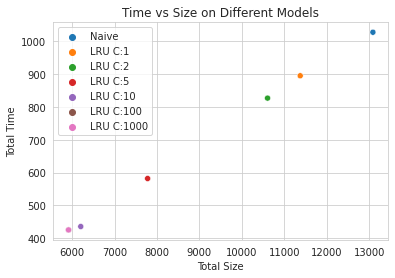

In [640]:
def RESULT_size_time():
    sizes, times, names = [], [], []
    _, _, _, naive_size, naive_time = MODEL_naive(1)
    sizes.append(naive_size)
    times.append(naive_time)
    names.append("Naive")
    
    for c in [1, 2, 5, 10, 100, 1000]:
        _, _, _, _, lru_size, lru_time, hitrate = MODEL_lru(1, c)
        sizes.append(lru_size)
        times.append(lru_time)
        names.append("LRU C:" + str(c))
        
    sns.scatterplot(x=sizes, y=times, hue=names)
    plt.xlabel("Total Size")
    plt.ylabel("Total Time")
    plt.title("Time vs Size on Different Models")
    return
        
    
RESULT_size_time()

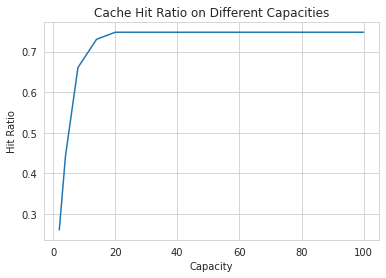

In [641]:
def RESULT_hitrate():
    hit_list, capsize = [], []
    for c in [2, 4, 8, 14, 20, 50, 100]:
        _, _, _, _, _, _, hitrate = MODEL_lru(1, c)
        hit_list.append(hitrate)
        capsize.append(c)
    
    sns.lineplot(x=capsize, y=hit_list)
    plt.xlabel("Capacity")
    plt.ylabel("Hit Ratio")
    plt.title("Cache Hit Ratio on Different Capacities")
    return

RESULT_hitrate()